# MCMC, HMC and Fisher matrix with $\texttt{SwiftC}_\ell$

In this notebook we use $\texttt{SwiftC}_\ell$ and CPJ to perform a mcmc, hmc and Fisher analysis of LSST Y10 $3\times2$ pt data as an example use case. We use scripts from https://github.com/LSSTDESC/forecasting_validation/  to compute the LSST mock data vector.

We will use the following packages:
 - CosmoPowerJAX
 - CCL
 - emcee for mcmc
 - blackjax for hmc
 - getdist

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import yaml

# emulators for cosmological functions
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX as CPJ
from jax_cosmo import Cosmology, background, transfer, constants
from scipy.constants import speed_of_light

# modules from
from srd_redshift_dists import SRDRedshiftDistributions
from binning import Binning

import pyccl as ccl
from swiftcl.cl import ClComp

### Data vector and covariance matrix from LSST 

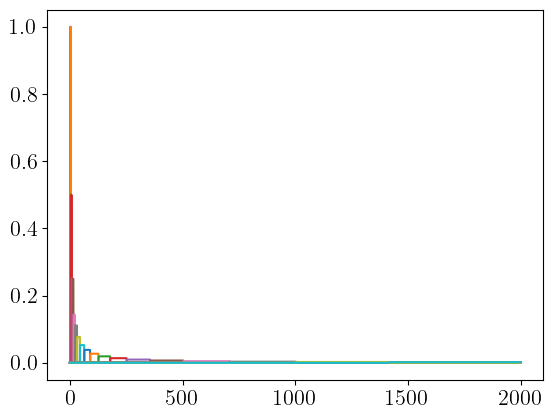

In [ ]:
# first lets get the parameters required for an accurate forecast
year = "10"
lsst_parameters = yaml.full_load(open("./parameters/lsst_desc_parameters.yaml"))
fsky = lsst_parameters[
    "sky"
][
    "frac_sky"
]  # sky fraction - we will just use 1/fsky as a proxy for masking in this simple forecast
lens_no_density = lsst_parameters["lens_sample"][year][
    "number_density"
]  # lens numberdensity
source_sigma_eps = lsst_parameters["source_sample"][year][
    "sigma_eps"
]  # ellipticity dispersion (shape noise)

lmin_bins = 2
lmax_bins = 2000
nbin_ell = 20
ell_edges = np.geomspace(lmin_bins, lmax_bins, nbin_ell + 1)
bins_centers = [
    ell_edges[i] ** (1 - (i + 0.5) / nbin_ell)
    * ell_edges[i + 1] ** ((i + 0.5) / nbin_ell)
    for i in range(nbin_ell)
]  # we will make the approximation that we can take the value at the bin centres for the covariance matrix

# create a binning matrix for the lenses and sources

ell_unbinned = np.arange(0, lmax_bins + 1)
n_ell_unbinned = len(ell_unbinned)
ell_windows = np.zeros([len(ell_unbinned), nbin_ell])
for i in range(nbin_ell):
    ell_windows[:, i] = (ell_unbinned >= ell_edges[i]) & (
        ell_unbinned <= ell_edges[i + 1]
    )
    ell_windows[:, i] /= np.sum(ell_windows[:, i])

In [6]:
def get_covariance(cls_gc=None, cls_ggl=None, cls_cs=None):
    import scipy.linalg

    num_lens_bins = len(cls_gc)
    num_ggl_bins = len(cls_ggl)
    num_cs_bins = len(cls_cs)

    print(num_lens_bins, num_ggl_bins, num_cs_bins)

    lens_noise_level = 1 / (lens_no_density * (180 / np.pi) ** 2)
    source_noise_level = (source_sigma_eps**2) / (
        lens_no_density * (180 / np.pi) ** 2 * 2
    )

    blocks = []
    # Galaxy clustering covariance
    if cls_gc is not None:
        diag = cls_gc.flatten() + lens_noise_level
        gc_cov = np.diag(diag**2)  # squared for covariance
        blocks.append(gc_cov)

    # Galaxy-galaxy lensing covariance
    if cls_ggl is not None:
        diag = cls_ggl.flatten()
        ggl_cov = np.diag(diag**2)  # squared for covariance
        blocks.append(ggl_cov)

    # Cosmic shear covariance
    if cls_cs is not None:
        diag = cls_cs.flatten() + source_noise_level
        cs_cov = np.diag(diag**2)  # squared for covariance
        blocks.append(cs_cov)

    covariance_matrix = scipy.linalg.block_diag(*blocks)

    ell_factors = np.array([(2 * ell + 1) * fsky / 2 for ell in bins_centers])
    print(ell_factors.shape)
    print(num_ggl_bins + num_lens_bins + num_cs_bins)
    ell_factors_repeated = np.repeat(
        ell_factors, num_ggl_bins + num_lens_bins + num_cs_bins
    )
    print(ell_factors_repeated.shape)
    print(covariance_matrix.shape)
    covariance_matrix /= ell_factors_repeated[:, None]

    return covariance_matrix

In [7]:
# # get redshift distribtuions from srd redshift dists
redshift_range = np.linspace(0.0, 3.5, 1000)
forecast_years = ["10"]  # LSST forecasting epochs

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {"sources": {}, "lenses": {}}

for year in forecast_years:
    source_dist = SRDRedshiftDistributions(
        redshift_range, galaxy_sample="source_sample", forecast_year=year
    )
    lens_dist = SRDRedshiftDistributions(
        redshift_range, galaxy_sample="lens_sample", forecast_year=year
    )

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(
        normalised=True, save_file=False
    )
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(
        normalised=True, save_file=False
    )


# Define a dictionary to store the bins
bins = {"sources": {}, "lenses": {}}
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = Binning(
        redshift_range, redshift_distribution["sources"][year], year
    ).source_bins(normalised=True, save_file=False)
    bins["lenses"][year] = Binning(
        redshift_range, redshift_distribution["lenses"][year], year
    ).lens_bins(normalised=True, save_file=False)

In [1]:
fiducial_cosmo = {
    "omega_b": 0.0491685 * 0.6727**2,
    "omega_cdm": (0.3156 - 0.0491685) * 0.6727**2,
    "h": 0.6727,
    "tau_reio": 0.05430842,
    "n_s": 0.9645,
    "ln10^{10}A_s": 3.0570637253347805,
    "cmin": 2.6,  # minimum halo concentration
    "eta_0": 0.7,  # halo bloating
    "sigma8": 0.8308890085010976,
    "gbias": 1.0,
}

# Bare CCL setup
a_1 = 1.0
eta_1 = -1.0
z_pivot = 0.62

In [ ]:
emu_nonlin = CPJ(probe="mpk_nonlin")
emu_lin = CPJ(probe="mpk_lin")

cosmo_params = {
    "omega_b": jnp.full(len(redshift_range), fiducial_cosmo["omega_b"]),
    "omega_cdm": jnp.full(len(redshift_range), fiducial_cosmo["omega_cdm"]),
    "h": jnp.full(len(redshift_range), fiducial_cosmo["h"]),
    "tau_reio": jnp.full(len(redshift_range), fiducial_cosmo["tau_reio"]),
    "n_s": jnp.full(len(redshift_range), fiducial_cosmo["n_s"]),
    "ln10^{10}A_s": jnp.full(len(redshift_range), fiducial_cosmo["ln10^{10}A_s"]),
    "z": jnp.array(redshift_range[::-1]),
    "cmin": jnp.full(len(redshift_range), 2.6),  # minimum halo concentration
    "eta_0": jnp.full(len(redshift_range), 0.7),  # halo bloating
}

P_nonlin = emu_nonlin.predict(cosmo_params)
P_lin = emu_lin.predict(cosmo_params)
k_nonlin = emu_nonlin.modes
k_lin = emu_lin.modes

In [ ]:
# set up a cosmology and for all bin pairs compute the datavector
cosmo = ccl.Cosmology(
    Omega_c=fiducial_cosmo["omega_cdm"] / fiducial_cosmo["h"] ** 2,
    Omega_b=fiducial_cosmo["omega_b"] / fiducial_cosmo["h"] ** 2,
    h=fiducial_cosmo["h"],
    sigma8=fiducial_cosmo["sigma8"],
    n_s=fiducial_cosmo["n_s"],
    w0=-1,
    wa=0,
)

pk_nonlin = ccl.pk2d.Pk2D(
    a_arr=1 / (1 + redshift_range[::-1]),
    lk_arr=np.log(k_nonlin),
    pk_arr=np.log(P_nonlin),
)
pk_lin = ccl.pk2d.Pk2D(
    a_arr=1 / (1 + redshift_range[::-1]), lk_arr=np.log(k_lin), pk_arr=np.log(P_lin)
)


# lets do 10 galaxy clustering auto correletions first (for now ignore mag bias - add this later)
data_vector = []

for i in range(len(bins["lenses"][year])):
    tracer1 = ccl.NumberCountsTracer(
        cosmo,
        has_rsd=False,  # add later?
        dndz=(redshift_range, bins["lenses"][year][i]),
        bias=(redshift_range, fiducial_cosmo["gbias"] * np.ones(len(redshift_range))),
    )
    tracer2 = ccl.NumberCountsTracer(
        cosmo,
        has_rsd=False,
        dndz=(redshift_range, bins["lenses"][year][i]),
        bias=(redshift_range, fiducial_cosmo["gbias"] * np.ones(len(redshift_range))),
    )
    cl_unbinned = ccl.angular_cl(
        cosmo,
        tracer1,
        tracer2,
        ell_unbinned,
        l_limber=2000,
        p_of_k_a=pk_nonlin,
        p_of_k_a_lin=pk_lin,
    )
    cl_binned = np.dot(ell_windows.T, cl_unbinned) * fsky
    data_vector.append(cl_binned)

# now the cross correlation of the lensing and source bins
# follow DESI SRD and include the combiantions where lens is behind source with allowing for 10% overlap (see https://github.com/CosmoLike/DESC_SRD/tree/master)
tracer_combos = [
    [0, 1],
    [0, 2],
    [0, 3],
    [0, 4],
    [1, 1],
    [1, 2],
    [1, 3],
    [1, 4],
    [2, 2],
    [2, 3],
    [2, 4],
    [3, 2],
    [3, 3],
    [3, 4],
    [4, 2],
    [4, 3],
    [4, 4],
    [5, 3],
    [5, 4],
    [6, 3],
    [6, 4],
    [7, 3],
    [7, 4],
    [8, 4],
    [9, 4],
]
for i in range(len(bins["lenses"][year])):
    for j in range(len(bins["sources"][year])):
        if [i, j] not in tracer_combos:
            continue
        tracer_1 = ccl.WeakLensingTracer(
            cosmo,
            has_shear=True,
            dndz=(redshift_range, bins["sources"][year][j]),
            use_A_ia=False,
        )

        tracer_2 = ccl.NumberCountsTracer(
            cosmo,
            has_rsd=False,
            dndz=(redshift_range, bins["lenses"][year][i]),
            bias=(
                redshift_range,
                fiducial_cosmo["gbias"] * np.ones(len(redshift_range)),
            ),
        )
        cl_unbinned = ccl.angular_cl(
            cosmo,
            tracer_1,
            tracer_2,
            ell_unbinned,
            l_limber=2000,
            p_of_k_a=pk_nonlin,
            p_of_k_a_lin=pk_lin,
        )
        cl_binned = np.dot(ell_windows.T, cl_unbinned) * fsky
        data_vector.append(cl_binned)

# now all the auto and cross_correlations of the shear bins
for i in range(len(bins["sources"][year])):
    for j in range(len(bins["sources"][year])):
        if i > j:
            continue
        tracer_1 = ccl.WeakLensingTracer(
            cosmo,
            has_shear=True,
            dndz=(redshift_range, bins["sources"][year][i]),
            use_A_ia=False,
        )
        tracer_2 = ccl.WeakLensingTracer(
            cosmo,
            has_shear=True,
            dndz=(redshift_range, bins["sources"][year][j]),
            use_A_ia=False,
        )

        cl_unbinned = ccl.angular_cl(
            cosmo,
            tracer_1,
            tracer_2,
            ell_unbinned,
            l_limber=2000,
            p_of_k_a=pk_nonlin,
            p_of_k_a_lin=pk_lin,
        )
        cl_binned = np.dot(ell_windows.T, cl_unbinned) * fsky
        data_vector.append(cl_binned)


data_vector = np.array(data_vector)
data_vector.shape

num_lens_bins = len(bins["lenses"][year])
num_source_bins = len(bins["sources"][year])
num_ggl_bins = len(tracer_combos)

(10, 20)


/cluster/project/refregier/lreymond/lsscl_jax_new/lib/python3.11/site-packages/pyccl/_nonlimber_FKEM.py:260: RuntimeWarning: invalid value encountered in scalar divide
  np.abs(cells[-1] / cl_limber_nonlin[-1] - 1) < limber_max_error


(35, 20)
(50, 20)


In [15]:
data_vector_flat = data_vector.flatten()

In [17]:
# lets make a covariance matrix
galaxy_clustering_auto_correlations = data_vector[:10]
ggl_cross_correlations = data_vector[10:17]
cs_cross_correlations = data_vector[17:]
covariance_matrix = get_covariance(
    cls_gc=galaxy_clustering_auto_correlations,
    cls_ggl=ggl_cross_correlations,
    cls_cs=cs_cross_correlations,
)

10 7 33
(20,)
50
(1000,)
(1000, 1000)


In [18]:
covariance_matrix.shape
inv_cov = np.linalg.inv(covariance_matrix)

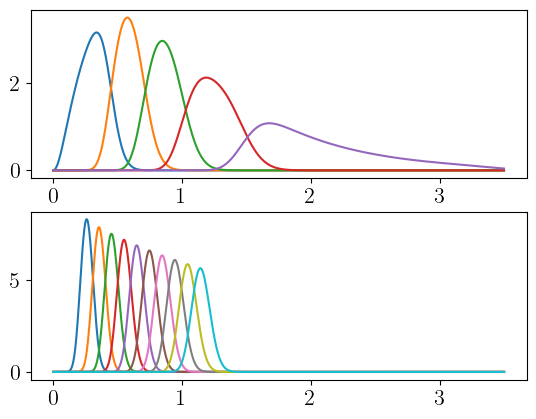

In [19]:
# lets plot the lenses and sources distributions in separate plots with different colors
keys_sources = bins["sources"]["10"].keys()
keys_lenses = bins["lenses"]["10"].keys()
fig, ax = plt.subplots(2, 1)
for key in keys_sources:
    ax[0].plot(redshift_range, bins["sources"]["10"][key], label=f"source bins {key}")
for key in keys_lenses:
    ax[1].plot(redshift_range, bins["lenses"]["10"][key], label=f"lens bins {key}")
plt.show()

In [21]:
indices = {}
indices_galaxy_clustering = []
indices_galaxy_galaxy_lensing = tracer_combos
indices_cosmic_shear = []
for i in range(num_lens_bins):
    indices_galaxy_clustering.append([i, i])
for i in range(num_source_bins):
    for j in range(num_source_bins):
        if i > j:
            continue
        indices_cosmic_shear.append([i, j])

indices["galaxy_clustering"] = indices_galaxy_clustering
indices["galaxy_galaxy_lensing"] = indices_galaxy_galaxy_lensing
indices["cosmic_shear"] = indices_cosmic_shear

### Compute the angular power spectrum with $\texttt{SwiftC}_\ell$

In [ ]:
# emulators for cosmological functions


def emu(n1, n2, k, O_b, O_cdm, h, tau_reio, n_s, A_s, sigma8, cmin, eta_0):
    # check condition, i.e. z_fid needs to be in range for z1 and z2
    z_fid_1 = (n1[-1, 0] - n1[0, 0]) / 2
    z_fid_2 = (n2[-1, 0] - n2[0, 0]) / 2
    z_fid = jnp.where(z_fid_1 < z_fid_2, z_fid_1, z_fid_2)

    # computing the power spectrum using CosmoPowerJAX
    emulator = CPJ(probe="mpk_nonlin")

    cosmo_params = {
        "omega_b": jnp.array([O_b]),
        "omega_cdm": jnp.array([O_cdm]),
        "h": jnp.array([h]),
        "tau_reio": jnp.array([tau_reio]),
        "n_s": jnp.array([n_s]),
        "ln10^{10}A_s": jnp.array([A_s]),
        "z": jnp.array([z_fid]),
        "cmin": jnp.array([cmin]),  # minimum halo concentration
        "eta_0": jnp.array([eta_0]),  # halo bloating
    }

    P = emulator.predict(cosmo_params)
    P_int = jnp.interp(k, emulator.modes, P)

    cosmo_params1 = {
        "omega_b": jnp.full(len(n1[:, 0]), O_b),
        "omega_cdm": jnp.full(len(n1[:, 0]), O_cdm),
        "h": jnp.full(len(n1[:, 0]), h),
        "tau_reio": jnp.full(len(n1[:, 0]), tau_reio),
        "n_s": jnp.full(len(n1[:, 0]), n_s),
        "ln10^{10}A_s": jnp.full(len(n1[:, 0]), A_s),
        "z": n1[:, 0],
        "cmin": jnp.full(len(n1[:, 0]), cmin),  # minimum halo concentration
        "eta_0": jnp.full(len(n1[:, 0]), eta_0),  # halo bloating
    }
    P1 = emulator.predict(cosmo_params1)
    P1_int = jnp.array(
        [jnp.interp(k, emulator.modes, P1[i]) for i in range(len(n1[:, 0]))]
    )

    cosmo_params2 = {
        "omega_b": jnp.full(len(n2[:, 0]), O_b),
        "omega_cdm": jnp.full(len(n2[:, 0]), O_cdm),
        "h": jnp.full(len(n2[:, 0]), h),
        "tau_reio": jnp.full(len(n2[:, 0]), tau_reio),
        "n_s": jnp.full(len(n2[:, 0]), n_s),
        "ln10^{10}A_s": jnp.full(len(n2[:, 0]), A_s),
        "z": n2[:, 0],
        "cmin": jnp.full(len(n2[:, 0]), cmin),  # minimum halo concentration
        "eta_0": jnp.full(len(n2[:, 0]), eta_0),  # halo bloating
    }
    P2 = emulator.predict(cosmo_params2)
    P2_int = jnp.array(
        [jnp.interp(k, emulator.modes, P2[i]) for i in range(len(n2[:, 0]))]
    )

    D_k1 = jnp.array([jnp.sqrt(P1_int[i, :] / P_int) for i in range(len(n1[:, 0]))])
    D_k2 = jnp.array([jnp.sqrt(P2_int[i, :] / P_int) for i in range(len(n2[:, 0]))])

    # computing chis and transfer function using cosmo-jax
    cosmo_jax = Cosmology(
        Omega_c=O_cdm / h**2,
        Omega_b=O_b / h**2,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=0.0,
        w0=-1.0,
        wa=0.0,
    )
    constants.H0 = h * 100
    chis1 = background.radial_comoving_distance(cosmo_jax, 1 / (1 + n1[:, 0])) / h
    chis2 = background.radial_comoving_distance(cosmo_jax, 1 / (1 + n2[:, 0])) / h

    H1 = background.H(cosmo_jax, 1 / (1 + n1[:, 0]))
    H2 = background.H(cosmo_jax, 1 / (1 + n2[:, 0]))

    return {
        "chis1": chis1,
        "chis2": chis2,
        "D_k1": D_k1,
        "D_k2": D_k2,
        "P": P_int,
        "H1": H1,
        "H2": H2,
    }

In [ ]:
# parameters for the computation
N_i = 200
N_fft = 512
ll = jnp.array(ell_unbinned)
k = jnp.geomspace(1e-4, 1e1, 300)
z_range = [redshift_range[0], redshift_range[-1]]

# instantiate class
c_gc = ClComp(
    z1=z_range,
    z2=z_range,
    k=k,
    l=ll,
    contr1="g",
    contr2="g",
    jit=False,
    N_interp=N_i,
    N=N_fft,
)
c_ggl = ClComp(
    z1=z_range,
    z2=z_range,
    k=k,
    l=ll,
    contr1="g",
    contr2="wl",
    jit=False,
    N_interp=N_i,
    N=N_fft,
)
c_cs = ClComp(
    z1=z_range,
    z2=z_range,
    k=k,
    l=ll,
    contr1="wl",
    contr2="wl",
    jit=False,
    N_interp=N_i,
    N=N_fft,
)


def get_cls(W_cl, W_ls, c_gc, c_ggl, c_cs, params):
    cls_gc = []
    cls_ggl = []
    cls_cs = []

    cosmo_func = emu(W_cl[0].T, W_cl[0].T, c_gc.c["k"], params)

    for i1, i2 in indices["galaxy_clustering"]:
        c_l = c_gc.C_l(
            W_cl[i1].T,
            W_cl[i2].T,
            cosmo_func["chis1"],
            cosmo_func["chis1"],
            cosmo_func["D_k1"],
            cosmo_func["D_k1"],
            cosmo_func["P"],
            H1=cosmo_func["H1"],
            H2=cosmo_func["H1"],
            H0=params["h"] * 100,
            O_m=(params["omega_cdm"] + params["omega_b"]) / params["h"] ** 2,
        )
        c_l = jnp.dot(ell_windows.T, c_l) * fsky
        cls_gc.append(c_l)
    cls_gc = jnp.column_stack(cls_gc)

    for i1, i2 in indices["galaxy_galaxy_lensing"]:
        c_l = c_ggl.C_l(
            W_cl[i1].T,
            W_ls[i2].T,
            cosmo_func["chis1"],
            cosmo_func["chis2"],
            cosmo_func["D_k1"],
            cosmo_func["D_k2"],
            cosmo_func["P"],
            H1=cosmo_func["H1"],
            H2=cosmo_func["H2"],
            H0=params["h"] * 100,
            O_m=(params["omega_cdm"] + params["omega_b"]) / params["h"] ** 2,
        )

        c_l = jnp.dot(ell_windows.T, c_l) * fsky
        cls_ggl.append(c_l)
    cls_ggl = jnp.column_stack(cls_ggl)

    for i1, i2 in indices["cosmic_shear"]:
        c_l = c_cs.C_l(
            W_ls[i1].T,
            W_ls[i2].T,
            cosmo_func["chis2"],
            cosmo_func["chis2"],
            cosmo_func["D_k2"],
            cosmo_func["D_k2"],
            cosmo_func["P"],
            H1=cosmo_func["H2"],
            H2=cosmo_func["H2"],
            H0=params["h"] * 100,
            O_m=(params["omega_cdm"] + params["omega_b"]) / params["h"] ** 2,
        )

        c_l = jnp.dot(ell_windows.T, c_l) * fsky
        cls_cs.append(c_l)
    cls_cs = jnp.column_stack(cls_cs)

    return jnp.concatenate(
        [
            cls_gc.T.flatten(),
            cls_ggl.T.flatten(),
            cls_cs.T.flatten(),
        ]
    )

In [26]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

W_source = []
for i, distribution in bins["sources"]["10"].items():
    W_source.append([redshift_range, distribution])

W_lens = []
for i, distribution in bins["lenses"]["10"].items():
    W_lens.append([redshift_range, distribution])

W_source = jnp.array(W_source)
W_lens = jnp.array(W_lens)

In [28]:
params = fiducial_cosmo.copy()
params["eta_0"] = 0.7
params["cmin"] = 2.6

cls = get_cls(W_lens, W_source, c_gc, c_ggl, c_cs, params)

/cluster/project/refregier/lreymond/lsscl_jax_new/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
data_vector_flat = data_vector.flatten()

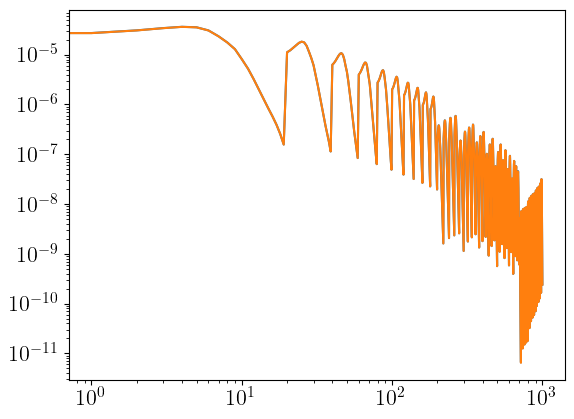

In [33]:
plt.loglog(data_vector_flat)
plt.loglog(cls)

### MCMC with emcee

In [34]:
from jax import vmap

param_order = ["omega_cdm", "h", "ln10^{10}A_s"]  # same order as emcee vector
truth = [fiducial_cosmo[p] for p in param_order]


# ------------------------------------------------------------------
# 2. JAX log‑likelihood function (compiled)
# ------------------------------------------------------------------
# @jax.jit
def gaussian_loglike(params):
    """Return Gaussian log‑likelihood for a single parameter vector.

    Parameters
    ----------
    params : (3,) jnp.ndarray  – (omega_cdm, h, ln10^{10}A_s)
    """
    param_dict = fiducial_cosmo.copy()
    param_dict["omega_cdm"], param_dict["h"], param_dict["ln10^{10}A_s"] = params

    model_vector = get_cls(W_lens, W_source, c_gc, c_ggl, c_cs, param_dict)
    delta = data_vector_flat - model_vector
    chi2 = delta.T @ inv_cov @ delta
    return -0.5 * chi2


# ------------------------------------------------------------------
# 3. Log‑probability with flat top‑hat priors (vectorised, JIT)
# ------------------------------------------------------------------
@jax.jit
def log_prob_vec(theta):
    """Vectorised log‑prob returning (nwalkers,) array for emcee (vectorize=True)."""
    # theta shape: (nwalkers, ndim)
    omega_cdm, h, lnA_s = theta[:, 0], theta[:, 1], theta[:, 2]

    inside_prior = (
        (omega_cdm > 0.0)
        & (omega_cdm < 1.0)
        & (h > 0.0)
        & (h < 1.0)
        & (lnA_s > 2.0)
        & (lnA_s < 4.0)
    )

    # Vectorise the likelihood over the *leading* dimension with vmap
    logl = vmap(gaussian_loglike)(theta)
    # jnp.where keeps compilation‑friendliness
    return jnp.where(inside_prior, logl, -jnp.inf)

In [ ]:
# ------------------------------------------------------------------
# 3. Run the sampler
# ------------------------------------------------------------------
ndim = len(param_order)
nwalkers = ndim * 4
rng = np.random.default_rng(42)

# start walkers in a small Gaussian ball around fiducial values
p0 = rng.normal(loc=truth, scale=[0.05 * v for v in truth], size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_vec, vectorize=True)

# burn‑in
state = sampler.run_mcmc(p0, 500, progress=True)  # 20%
sampler.reset()
N = 2500

# production run
state = sampler.run_mcmc(p0, N, progress=True)

# save chain to disk (optional)
# np.savez("chain_emcee_Limber.npz", chain=sampler.get_chain(flat=False), thin = 20)

100%|██████████| 2500/2500 [03:23<00:00, 12.26it/s]


In [ ]:
%matplotlib inline

from getdist.mcsamples import MCSamples
from getdist import plots

# ------------------------------------------------------------------
# 4. Plot with getdist
# ------------------------------------------------------------------

chain_flat = sampler.get_chain(discard=0, flat=True)
samples = MCSamples(
    samples=chain_flat[::15],
    names=param_order,
    labels=[r"\omega_{\rm cdm}", r"h", r"\ln10^{10}A_s"],
    ranges={
        "omega_cdm": (0.05, 0.5),
        "h": (0.4, 1.0),
        "ln10^{10}A_s": (2.2, 3.9),
    },
    label="MCMC",
)

g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True, markers=fiducial_cosmo)
# plt.savefig('MCMC.png')

### Fisher matrix

In [ ]:
def get_der(
    W_cl,
    W_ls,
    c_gc,
    c_ggl,
    c_cs,
    omega_b,
    omega_cdm,
    h,
    tau_reio,
    n_s,
    ln10A_s,
    sigma8,
    cmin,
    eta_0,
):
    params = {
        "omega_b": omega_b,
        "omega_cdm": omega_cdm,
        "h": h,
        "tau_reio": tau_reio,
        "n_s": n_s,
        "ln10^{10}A_s": ln10A_s,
        "sigma8": sigma8,
        "cmin": cmin,
        "eta_0": eta_0,
    }

    return get_cls(W_cl, W_ls, c_gc, c_ggl, c_cs, params)

In [35]:
from jax import jacfwd

der_params = ["omega_cdm", "h", "ln10^{10}A_s"]
der = np.array(
    jacfwd(get_der, argnums=[6, 7, 10])(
        W_lens,
        W_source,
        c_gc,
        c_ggl,
        c_cs,
        params["omega_b"],
        params["omega_cdm"],
        params["h"],
        params["tau_reio"],
        params["n_s"],
        params["ln10^{10}A_s"],
        params["sigma8"],
        params["cmin"],
        params["eta_0"],
    )
)

/cluster/project/refregier/lreymond/lsscl_jax_new/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [36]:
F = jnp.einsum("pn, nm, qm -> pq", der, np.linalg.inv(covariance_matrix), der)

Removed no burn in


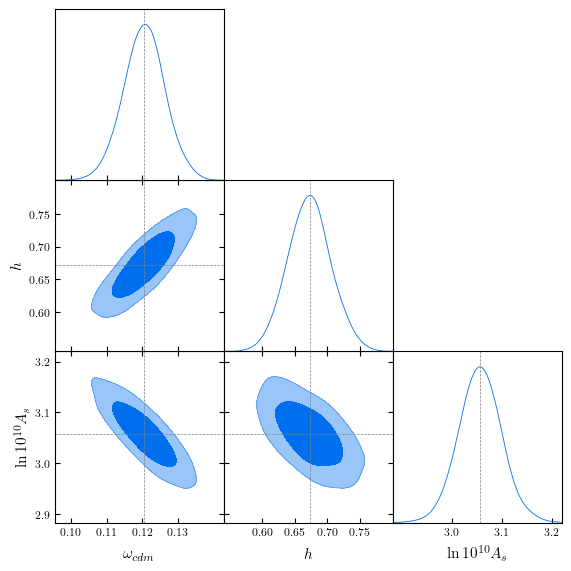

In [ ]:
%matplotlib inline

from getdist import plots
import getdist

mean = np.array([params[p] for p in der_params])
samps = np.random.multivariate_normal(mean, np.linalg.inv(F), size=2000)
samples_fisher = getdist.MCSamples(
    samples=samps,
    names=der_params,
    labels=["\omega_{cdm}", "h", "\ln10^{10}A_s"],
    label="Fisher",
)
# np.savez("chain_Fisher.npz", chain=samps)

g = plots.get_subplot_plotter()
g.triangle_plot(samples_fisher, filled=True, markers=fiducial_cosmo)
# plt.savefig('Fisher.png')

### HMC

In [ ]:
def gaussian_loglike(params):
    """Return Gaussian log‑likelihood for a single parameter vector.

    Parameters
    ----------
    params : (3,) jnp.ndarray  – (omega_cdm, h, ln10^{10}A_s)
    """
    param_dict = fiducial_cosmo.copy()
    param_dict["omega_cdm"], param_dict["h"], param_dict["ln10^{10}A_s"] = params

    model_vector = get_cls(W_lens, W_source, c_gc, c_ggl, c_cs, param_dict)
    delta = data_vector_flat - model_vector
    chi2 = delta.T @ inv_cov @ delta
    return -0.5 * chi2


@jax.jit
def log_prob_impl(theta):
    # theta shape: (ndim)
    omega_cdm, h, lnA_s = theta[0], theta[1], theta[2]

    inside_prior = (
        (omega_cdm > 0.0)
        & (omega_cdm < 1.0)
        & (h > 0.0)
        & (h < 1.0)
        & (lnA_s > 2.0)
        & (lnA_s < 4.0)
    )

    # Vectorise the likelihood over the *leading* dimension with vmap
    logl = gaussian_loglike(theta)
    # jnp.where keeps compilation‑friendliness
    return jnp.where(inside_prior, logl, -jnp.inf)


@jax.custom_vjp
def log_prob(x):
    return log_prob_impl(x)


def log_prob_fwd(x):
    # In this case, we return the function's output and save the input 'x'
    # to be used in the backward pass.
    return log_prob(x), x


def log_prob_bwd(x, g):
    """
    x: The value saved from the fwd pass (the original input).
    g: The incoming gradient from the layer above (output cotangent).
       For a scalar function, this will be 1.0.
    """
    # Compute the Jacobian of the primitive function using FORWARD-MODE AD.
    J = jax.jacfwd(log_prob_impl)(x)

    # The result of a VJP is g * J.
    # The result must be a tuple, with one element per primal input.
    return (g * J,)


log_prob.defvjp(log_prob_fwd, log_prob_bwd)

In [ ]:
param_order = ["omega_cdm", "h", "ln10^{10}A_s"]  # same order as emcee vector
truth = [fiducial_cosmo[p] for p in param_order]

rng = np.random.default_rng(42)
p0 = rng.normal(loc=truth, scale=[0.05 * v for v in truth])

jax.grad(log_prob)(p0)

/cluster/project/refregier/lreymond/lsscl_jax_new/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# from https://blackjax-devs.github.io/blackjax/examples/quickstart.html#nuts
import jax, blackjax
from datetime import date


def _get_p(
    initial_pos=None,
    num_samples=100,  # post-warm-up draws
    num_warmup=None,  # warm-up steps (defaults to 10 % of draws)
    target_accept=0.8,
    max_num_doublings=10,
    verbose=True,
):
    """Run a single-chain BlackJAX NUTS sampler (JIT-compiled).

    Parameters
    ----------
    initial_pos : array-like
        Starting point of the Markov chain.
    num_samples : int
        Number of *post-warm-up* samples to draw.
    num_warmup : int | None
        Number of warm-up (adaptation) steps.  Defaults to 10 % of ``num_samples``.
    target_accept : float
        Dual-averaging target acceptance probability.
    max_num_doublings : int
        Maximum tree depth used by NUTS *after* warm-up (controls max leapfrog steps).
    verbose : bool
        Print basic diagnostics if ``True``.
    """

    if initial_pos is None:
        initial_pos = _initial_pos

    if num_warmup is None:
        num_warmup = num_samples // 10

    # ── RNG setup ──────────────────────────────────────────────
    rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
    rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

    # ── Warm-up / adaptation ──────────────────────────────────
    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        log_prob,
        target_acceptance_rate=target_accept,
        max_num_doublings=max_num_doublings,
    )

    (state, parameters), _ = warmup.run(
        warmup_key,
        initial_pos,
        num_steps=num_warmup,
    )

    # include the user-selected tree depth *only* in the final kernel
    kernel = blackjax.nuts(
        log_prob,
        **parameters,
    ).step

    # ── JIT-compiled sampling loop ────────────────────────────
    def inference_loop(key, init_state):
        @jax.jit
        def one_step(carry, k):
            new_state, info = kernel(k, carry)
            return new_state, (
                new_state.position,
                info.acceptance_rate,
                info.is_divergent,
            )

        keys = jax.random.split(key, num_samples)
        _, (positions, accepts, divergences) = jax.lax.scan(one_step, init_state, keys)
        return positions, accepts, divergences

    positions, accepts, divergences = inference_loop(sample_key, state)
    _ = positions.block_until_ready()

    if verbose:
        acc = jax.numpy.mean(accepts).item()
        div = jax.numpy.mean(divergences).item()
        print(f"avg accept rate: {acc:0.2f}, frac divergent: {div:0.3f}")
        print("sampling done in %.2s sec." % walltime_sampling)

    extras = {"acceptance_rate": acc, "divergences": div}
    return positions, extras

In [ ]:
from time import perf_counter as tic

param_order = ["omega_cdm", "h", "ln10^{10}A_s"]  # same order as emcee vector
truth = [fiducial_cosmo[p] for p in param_order]

rng = np.random.default_rng(42)
p0 = rng.normal(loc=truth, scale=[0.05 * v for v in truth])

chain_hmc = _get_p(initial_pos=p0, num_samples=2000, num_warmup=100)
# np.savez("chain_hmc_500.npz", chain=chain_hmc[0], timing = chain_hmc[1])

warmup done in 89 sec.
avg accept rate: 0.97, frac divergent: 0.000
sampling done in 18 sec.
2784.5551051492803


In [ ]:
%matplotlib inline

from getdist.mcsamples import MCSamples
from getdist import plots

param_order = ["omega_cdm", "h", "ln10^{10}A_s"]  # same order as emcee vector
truth = [fiducial_cosmo[p] for p in param_order]

samples_hmc = MCSamples(
    samples=chain_hmc,
    names=param_order,
    labels=[r"\omega_{\rm cdm}", r"h", r"\ln10^{10}A_s"],
    ranges={
        "omega_cdm": (0.05, 0.5),
        "h": (0.4, 1.0),
        "ln10^{10}A_s": (2.2, 3.9),
    },
    label="HMC",
)


g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 16.0
g.settings.axes_fontsize = 16.0
g.settings.legend_fontsize = 16.0
g.triangle_plot(
    [samples_hmc], filled=True, markers=fiducial_cosmo, legend_labels=["HMC"]
)
legend = g.fig.legends[0]  # Get the first legend object
legend.set_frame_on(False)
# plt.savefig('HMC.pdf')